## Demo:  Compare AlexNet and ResNet50

In [2]:
import torch
import torch.nn as nn
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import os
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import dsutils 
import metrics

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


### Load some pretrained networks

In [12]:
# Choose some pretrained models from torch hub

alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# resnet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# resnet101 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# resnet152 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
# vgg16 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

alexnet.eval().to(device)
resnet50.eval().to(device)

# resnet152.eval().to(device)
# resnet101.eval().to(device)
# resnet50.eval().to(device)
# resnet34.eval().to(device)
# resnet18.eval().to(device)
# alexnet.eval().to(device)
# vgg16.eval().to(device)

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')


Using cache found in /Users/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/sharvey/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


### Get the filenames of the sample images

In [13]:
# filenames for imagenet sample images

# You must replace this with a path to the directory that contains the images you want to use.  We are just using a set of imagenet sample images from https://github.com/EliSchwartz/imagenet-sample-images.  
# Make sure you configure the directory structure of the images to be amenable to DataLoader.  

fnames = os.listdir('../imagenet-sample-images/dataset/test/')
fnames.sort()

M = len(fnames)  # number of test samples

### Test that the neural networks are working correctly

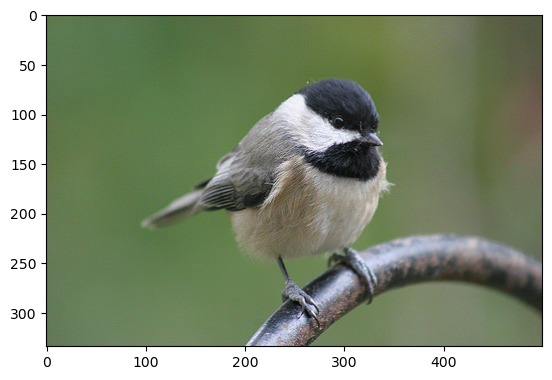

In [14]:
# Show an image

trial_image = fnames[19]
input_image = Image.open('../imagenet-sample-images/dataset/test/'+ trial_image)

plt.imshow(input_image)

In [15]:
# Define preprocessing 

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [16]:
# preprocess one image
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model


In [17]:
# Test a model (run forward pass with test image)

with torch.no_grad():
    output = torch.nn.functional.softmax(alexnet(input_batch), dim=1)

results = utils.pick_n_best(predictions=output, n=3)

sample 0: [('chickadee', '100.0%'), ('jay', '0.0%'), ('bulbul', '0.0%')]


### Extract intermediate representations from two neural networks

In [23]:
# Split the network in two halfs and extract the representations at a specified layer

# AlexNet

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_dir = '../imagenet-sample-images'

dataset = datasets.ImageFolder(data_dir, transform=preprocess)
trainloader = DataLoader(dataset, batch_size=M, shuffle=False, num_workers=0)  # set num_workers to 0 if you are running this on a Mac

module1 = list(alexnet.children())[:1]
module2 = list(alexnet.children())[1:2]
module3 = list(alexnet.children())[2:]

anet_1st = nn.Sequential(*[*module1, *module2, dsutils.Flatten(), module3[0][0:6]] )

anet_2nd = nn.Sequential(*[module3[0][6:], dsutils.SoftMaxModule() ])


with torch.no_grad():
    for inputs, _ in trainloader:
        x1 = anet_1st(inputs)
        x2 = anet_2nd(x1) 
        # output = torch.nn.functional.softmax(alexnet(inputs), dim=1) # check classifications

# Check results
# results = utils.pick_n_best(predictions=x2, n=3)

In [25]:
# Split the network in two halfs and extract the representations at a specified layer

# ResNet 50

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_dir = '../imagenet-sample-images'
dataset = datasets.ImageFolder(data_dir, transform=preprocess)
trainloader = DataLoader(dataset, batch_size=M, shuffle=False, num_workers=0)  # set num_workers to 0 if you are running this on a Mac

module1 = list(resnet50.children())[:9]
module2 = list(resnet50.children())[9:]

rnet50_1st = nn.Sequential(*[*module1, dsutils.Flatten()])
rnet50_2nd = nn.Sequential(*[*module2, dsutils.SoftMaxModule() ])

with torch.no_grad():
    for inputs, _ in trainloader:
        y1 = rnet50_1st(inputs)
        y2 = rnet50_2nd(y1_old) 
        # output = torch.nn.functional.softmax(resnet50(inputs), dim=1) # check classifications

# Check results
# results = utils.pick_n_best(predictions=y2, n=3)  # uncomment this line to see the classifications of the test images

sample 0: [('tench, Tinca tinca', '96.4%'), ('goldfish, Carassius auratus', '1.2%'), ('puffer, pufferfish, blowfish, globefish', '0.9%')]
sample 1: [('goldfish, Carassius auratus', '79.9%'), ('tench, Tinca tinca', '19.6%'), ('puffer, pufferfish, blowfish, globefish', '0.2%')]
sample 2: [('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', '92.1%'), ('tiger shark, Galeocerdo cuvieri', '3.9%'), ('dugong, Dugong dugon', '2.5%')]
sample 3: [('tiger shark, Galeocerdo cuvieri', '99.9%'), ('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', '0.1%'), ('hammerhead, hammerhead shark', '0.0%')]
sample 4: [('swimming trunks, bathing trunks', '57.3%'), ('gar, garfish, garpike, billfish, Lepisosteus osseus', '23.3%'), ('snorkel', '4.2%')]
sample 5: [('electric ray, crampfish, numbfish, torpedo', '95.1%'), ('stingray', '4.9%'), ('strainer', '0.0%')]
sample 6: [('stingray', '52.2%'), ('electric ray, crampfish, numbfish, torpedo', '4

### Compare Linear CKA and normalized ADS score for a = 0, b = 1

In [26]:
# Compute linear CKA for comparison

cka = metrics.LinearCKA(center_columns=True)
CKAscore = cka.score(x1.numpy(),y1.numpy())
print('The CKA score is ' + str(CKAscore))

The CKA score is 0.5677244


In [27]:
# Compute the normalized ADS score for a particular task covariance matrix, Cz = Identity

ds = metrics.LinearDecodingSimilarity(center_columns=True, a = 0, b = 1)

Cz = np.identity(M)

DSscore = ds.score(x1.numpy(),y1.numpy(),Cz)
print('The DS score is ' + str(DSscore))

The DS score is 0.5677187255295436


### Study ADS with empirical covariance matrices for random task ensembles 

In [23]:
# Compute the normalized ADS score for a particular task covariance matrix, Cz, generated from 10 random binary partitions

ds = metrics.LinearDecodingSimilarity(center_columns=True, a=0, b=1)

Cz = dsutils.random_partitions_cov_matrix(M,10)

DSscore = ds.score(x1.numpy(),y1.numpy(),Cz)
print('The DS score is ' + str(DSscore))

The DS score is 0.39250226980335357


In [24]:
# Compute the normalized ADS score for a particular task covariance matrix, Cz, generated from 10 random Gaussian tasks

ds = metrics.LinearDecodingSimilarity(center_columns=True, a=0, b=1)

Cz = dsutils.gaussian_partitions_cov_matrix(M,10)

DSscore = ds.score(x1.numpy(),y1.numpy(),Cz)
print('The DS score is ' + str(DSscore))

The DS score is 0.4602383663050949


### Study convergence of random task ensembles to CKA

In [102]:
# Random binary partitions.  Each sample is assigned a value of +1 or -1 with probability 1/2.  

ds = metrics.LinearDecodingSimilarity(center_columns=True, a=0, b=1)

X = x1.numpy()
Y = y1.numpy()

M = np.shape(x1.numpy())[0]

ds_scores_binary_all = []

for trial in range(0,5):  # number of independent trials
    n = 1
    Ns = [n]
    Cz = dsutils.PartitionsCovMatrix(M, n, method='binary')
    Cz.initialize_cov_matrix()
    
    ds_scores_binary = [ds.score(x1.numpy(),y1.numpy(),Cz.matrix)]
    
    delta_n = 10  # number of samples to add to the empirical covariance matrix at each iteration (must be an integer)
    for i in range(1,30):
        Cz.update_cov_matrix(delta_n)
        ds_scores_binary.append(ds.score(X,Y,Cz.matrix))
        n = Cz.n
        Ns.append(n)
        # print(i)

    ds_scores_binary_all.append(ds_scores_binary)
    print(trial)

    
    
    

0
1
2
3
4


In [105]:
# Random Gaussian task.  Each sample is assigned a draw from the standard normal distribution.

ds = metrics.LinearDecodingSimilarity(center_columns=True, a=0, b=1)

X = x1.numpy()
Y = y1.numpy()

M = np.shape(x1.numpy())[0]

ds_scores_gauss_all = []

for trial in range(0,5): # number of independent trials
    n = 1
    Ns = [n]
    Cz = dsutils.PartitionsCovMatrix(M, n, method='gaussian')
    Cz.initialize_cov_matrix()
    
    ds_scores_gauss = [ds.score(x1.numpy(),y1.numpy(),Cz.matrix)]
    
    delta_n = 10  # number of samples to add to the empirical covariance matrix at each iteration (must be an integer)
    for i in range(1,30):
        Cz.update_cov_matrix(delta_n)
        ds_scores_gauss.append(ds.score(X,Y,Cz.matrix))
        n = Cz.n
        Ns.append(n)
        # print(i)

    ds_scores_gauss_all.append(ds_scores_gauss)
    print(trial)


0
1
2
3
4


### Look at coarse category decoding task

In [106]:
import pandas as pd
import random

df = pd.read_csv('imagenet_categories_synset.csv')
print(df)

     index     synset                                              words  \
0        0  n01440764                                 tench, Tinca tinca   
1        1  n01443537                        goldfish, Carassius auratus   
2        2  n01484850  great white shark, white shark, man-eater, man...   
3        3  n01491361                    tiger shark, Galeocerdo cuvieri   
4        4  n01494475                       hammerhead, hammerhead shark   
..     ...        ...                                                ...   
995    995  n13044778                                          earthstar   
996    996  n13052670  hen-of-the-woods, hen of the woods, Polyporus ...   
997    997  n13054560                                             bolete   
998    998  n13133613                              ear, spike, capitulum   
999    999  n15075141       toilet tissue, toilet paper, bathroom tissue   

    categories  
0         fish  
1         fish  
2        shark  
3        shark  
4 

In [107]:
cats = pd.unique(df["categories"])
cats[:]

array(['fish', 'shark', 'bird', 'salamander', 'frog', 'turtle', 'lizard',
       'crocodile', 'dinosaur', 'snake', 'trilobite', 'arachnid', 'bug',
       'ungulate', 'monotreme', 'marsupial', 'coral', 'mollusk',
       'crustacean', 'marine mammals', 'dog', 'wild dog', 'cat',
       'wild cat', 'bear', 'sloth', 'mongoose', 'butterfly',
       'echinoderms', 'rabbit', 'rodent', 'plant', 'hog', 'ferret',
       'armadillo', 'primate', 'technology', 'clothing', 'instrument',
       'boat', 'aircraft', 'furniture', 'vehicle', 'decor',
       'outdoor scene', 'weapon', 'accessory', 'building',
       'sports equipment', 'toy', 'tool', 'other', 'container', 'ball',
       'hat', 'lab equipment', 'food', 'paper', 'train', 'cooking',
       'electronics', 'fence', 'fruit', 'person', 'vegetable', 'flower',
       'fungus'], dtype=object)

In [108]:
# Make coarse category decoding tasks

z = []
for k in cats[:]:
    zpd = (df["categories"] == k)
    zpd = zpd[0:M]
    zarr = 2*zpd.to_numpy() - 1
    z.append(zarr.reshape(M,1))

In [109]:
ds = metrics.LinearDecodingSimilarity(center_columns=True, a = 0, b = 1)

Cz = dsutils.bespoke_cov_matrix(z)

DSscore = ds.score(x1.numpy(),y1.numpy(),Cz)
print('The DS score is ' + str(DSscore))

The DS score is 0.6468694384156451


### Plot the random ensembles and the coarse category decoding task

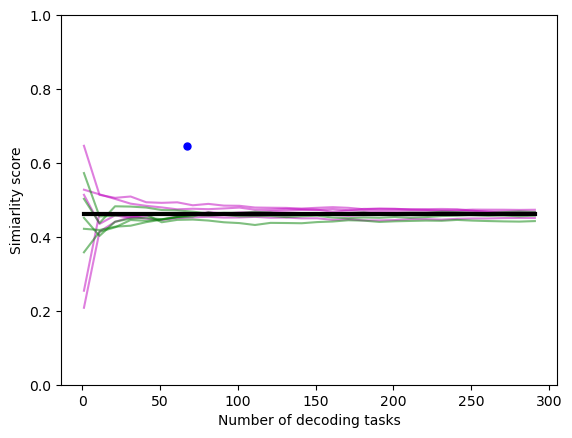

In [118]:
for s in np.arange(len(ds_scores_binary_all)):
    plt.plot(Ns,ds_scores_binary_all[s],label='Random partitions decoding similarity',color='m',alpha=0.5)

for s in np.arange(len(ds_scores_gauss_all)):
    plt.plot(Ns,ds_scores_gauss_all[s],label='Gaussian decoding similarity',color='g',alpha=0.5)

plt.plot(Ns,CKAscore*np.ones(len(Ns)), label='CKA',color='black',linewidth=3)
plt.plot(len(cats),DSscore,'.b',markersize=10, label='Coarse category decoding')  # from coarse decoding task 

plt.ylim(0,1)

plt.xlabel('Number of decoding tasks')
plt.ylabel('Simiarlity score')

# plt.savefig('rn50_anet_ds_cka_a0b1_binary_gaussian_penultlayers.pdf')